In [1]:
%matplotlib inline

# Dependencies and Setup
#from stateAbbr import us_state_abbrev
import matplotlib.pyplot as plt
import pandas as pd
import numpy as np
import requests
import datetime as dt 
import gzip
from pandas.io.json import json_normalize
import pprint as pp
import os
import json
import gmaps
import ipywidgets as widget
import csv
from pandas import pivot_table,DataFrame,crosstab
#Pip instsall pyzipcode
#from uszipcode import ZipcodeSearchEngine
 

#zc = search.by_zipcode(77065) 
#pp.pprint(zc)
from os import listdir
from os.path import isfile,join
#import filesplit
# used Bash and linux split command to break up file
#split --lines=300000 --numeric-suffixes --suffix-length=3 arcos_all_washpost.tsv aaww
#int 3000000 line segments.

DEAfilespath ="E:\\RiceProjectData\\DEAData"
DEAFilelist=[f for f in listdir(DEAfilespath) if isfile(join(DEAfilespath,f))]
DEAFiledict={}

def Pickupfromcount(num):
    '''
    This sets a dictionary of filenames to 
    to = True, meaning that the files have
    already been processed, and that any thing
    where it is false should be processed
    '''
    cntr=0
    #Keep Track of Processed Files
    for f in DEAFilelist:
        DEAFiledict.update({f:(cntr<num)})
        cntr+=1
    
# bigfile="E:\\RiceProjectData\\DEAData\\aaww001"
# filename0='arcos-tx-statewide-pharmacy.tsv'
# filename1='arcos-tx-statewide-distributor.tsv'
# filename2='arcos-tx-statewide-labeler.tsv'
Outputhdr=['REPORTER_NAME',
 'BUYER_NAME',
 'BUYER_ZIP',
 'BUYER_COUNTY',
 'DRUG_NAME',
 'QUANTITY',
 'UNIT',
 'DOSAGE_UNIT',
 'TRANSACTION_ID',
 'Ingredient_Name', 
 'dos_str']

Masterhdr=['REPORTER_DEA_NO',
 'REPORTER_BUS_ACT',
 'REPORTER_NAME',
 'REPORTER_ADDL_CO_INFO',
 'REPORTER_ADDRESS1',
 'REPORTER_ADDRESS2',
 'REPORTER_CITY',
 'REPORTER_STATE',
 'REPORTER_ZIP',
 'REPORTER_COUNTY',
 'BUYER_DEA_NO',
 'BUYER_BUS_ACT',
 'BUYER_NAME',
 'BUYER_ADDL_CO_INFO',
 'BUYER_ADDRESS1',
 'BUYER_ADDRESS2',
 'BUYER_CITY',
 'BUYER_STATE',
 'BUYER_ZIP',
 'BUYER_COUNTY',
 'TRANSACTION_CODE',
 'DRUG_CODE',
 'NDC_NO',
 'DRUG_NAME',
 'QUANTITY',
 'UNIT',
 'ACTION_INDICATOR',
 'ORDER_FORM_NO',
 'CORRECTION_NO',
 'STRENGTH',
 'TRANSACTION_DATE',
 'CALC_BASE_WT_IN_GM',
 'DOSAGE_UNIT',
 'TRANSACTION_ID',
 'Product_Name',
 'Ingredient_Name',
 'Measure',
 'MME_Conversion_Factor',
 'Combined_Labeler_Name',
 'Revised_Company_Name',
 'Reporter_family',
 'dos_str']
def tsvtodfSPLIT(filename,hdrs,inserthdr=True):
    tlist=[]
    with open(filename) as tsvfile:
        #df=pd.DataFrame.from_csv(tsvfile)
        reader = csv.reader(tsvfile, delimiter='\t')
        for row in reader:
            tlist.append(row)

        dfp = pd.DataFrame(tlist)#
        #and make header names
        #hdrslist=dfp.T[0].tolist()
        if inserthdr:           
            dfp.columns=hdrs #make columns 
        dfp.dropna
        dfr = dfp.reset_index()
        return dfr

def ParseCSVFiles(Startfromcnt=-1):
    Pickupfromcount(Startfromcnt) #skip the first 285 records
    filelocs={} #dictionary of State:CSV filenames
    counter=0 #initialize counter
    Sourcedir="E:\\RiceProjectData\\DEAData" #directory containing the split files from the master DEA database
    Targetdir ="C:\\DEAData\\"                  #directory where to write data    

    for f in DEAFilelist:    

        basedir =Targetdir + f  
        print(basedir)
        counter+=1
        if not DEAFiledict[f]:
            df0 =tsvtodfSPLIT(basedir,Masterhdr,True) #reads in about 300,000 lines of master record  from a file that has been produced by a split

           #The reduced DataFrame set to produce from the master dataset
            dfRed = df0[[
             'REPORTER_NAME',   
             'BUYER_NAME',   
             'BUYER_ADDRESS1',
             'BUYER_CITY',
             'BUYER_STATE',
             'BUYER_COUNTY',   
             'BUYER_ZIP',
             'TRANSACTION_DATE',
             'DRUG_NAME',
             'CALC_BASE_WT_IN_GM',              
             'QUANTITY',
             'DOSAGE_UNIT'             
             ]]
          
            df0.dropna
            #df0['QUANTITY'].astype(float)
            states=(dfRed.BUYER_STATE.unique())
            #outpath="E:\\RiceProjectData\\DEAData\\StateCSVfiles\\"
            outpath="C:\\DEAData\\StateCSVfiles\\"
            for s in states:
                dfs =dfRed.loc[dfRed['BUYER_STATE'] == s]
                if s in filelocs: #append data to existing CSV file i
                    curfile=filelocs[s] # Get the file name
                    #print(curfile + ' is being processd')
                    dfs.to_csv(curfile, mode='a',index=None,header=False) #append panda dataframe contents to CSV file
                    DEAFiledict.update({f:True}) #This file has been processed if this is set to True            
                else:  #Creates the filename for the first time and then copies the header 
                    tfile=outpath + s+'_DEA_data.csv'   #State     
                    filelocs.update( {s : tfile})
                    dfs.to_csv(tfile, index = None, header=True) #Don't forget to add '.csv' at the end of the path)
                    #print(tfile)
                #end if of filelocs (CSV files)
             #end For of States  
        #end if for DEADict
    #End For of DEAFileList            

# ParseCSVFiles(-1) # only uncomment this line if you want to run the routine that 
                    # creates the CSV files from the split files                      
 

### Process Data
Bring in as state and use Pivot Table to subcategorize

In [68]:
dffips = pd.read_csv("FipsCodes.csv")
dffips.columns= ["FIPS","NAME","STATE","COUNTY"]
nfips=dffips.drop(['NAME'],axis=1)
nfips.head()                     

FIPS STATE   COUNTY
0  1001    AL  AUTAUGA
1  1003    AL  BALDWIN
2  1005    AL  BARBOUR
3  1007    AL     BIBB
4  1009    AL   BLOUNT

In [52]:
def normalize(df):
    result = df.copy()
    for feature_name in df.columns:
        max_value = df[feature_name].max()
        min_value = df[feature_name].min()
        result[feature_name] =100* (df[feature_name] - min_value) / (max_value - min_value)
    return result
def lineplot(ax,df,cntr):
       # Build a scatte,sr plot for each data type
    df.plot.line()

    # Incorporate the other graph properties
    plt.title("s" ,fontsize=15)
    plt.xlabel("Percentage Ratio")
    plt.ylabel("Wt - Year")
    plt.grid(True)
    #plt.tight_layout()
    # Save the figure
    plt.savefig("s.png")

['AL',
 'AK',
 'AZ',
 'AR',
 'CA',
 'CO',
 'CT',
 'DE',
 'DC',
 'FL',
 'GA',
 'HI',
 'ID',
 'IL',
 'IN',
 'IA',
 'KS',
 'KY',
 'LA',
 'ME',
 'MD',
 'MA',
 'MI',
 'MN',
 'MS',
 'MO',
 'MT',
 'NE',
 'NV',
 'NH',
 'NJ',
 'NM',
 'NY',
 'NC',
 'ND',
 'OH',
 'OK',
 'OR',
 'PA',
 'RI',
 'SC',
 'SD',
 'TN',
 'TX',
 'UT',
 'VT',
 'VA',
 'WA',
 'WV',
 'WI',
 'WY',
 'AS',
 'MP',
 'GU',
 'PR',
 'VI']


C:\ProgramData\Anaconda3\envs\RiceCrispee\lib\site-packages\pandas\plotting\_core.py:304: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).
  fig = self.plt.figure(figsize=self.figsize)


FileNotFoundError: [Errno 2] File b'c:\\DEAdata\\StateCSVfiles\\AS_DEA_data.csv' does not exist: b'c:\\DEAdata\\StateCSVfiles\\AS_DEA_data.csv'

<Figure size 360x216 with 0 Axes>

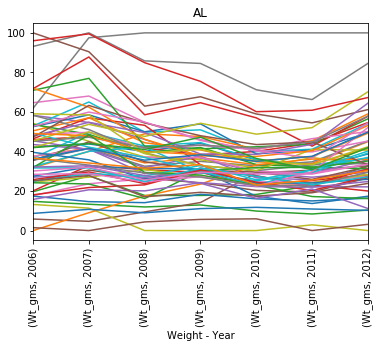

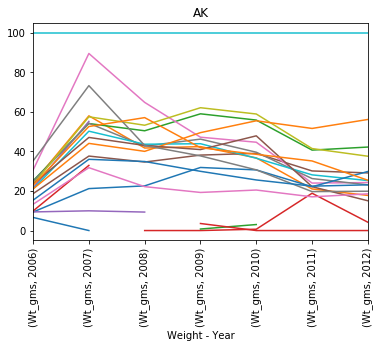

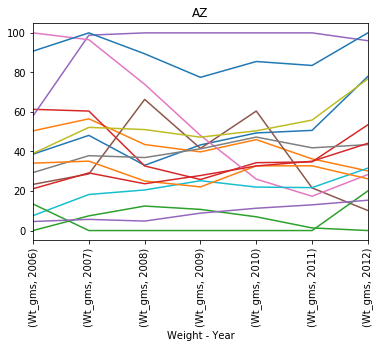

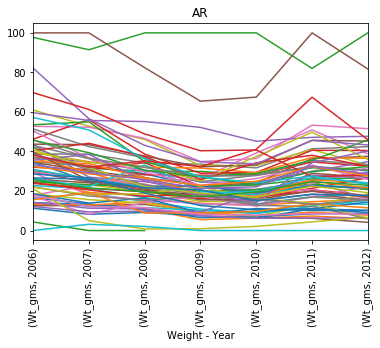

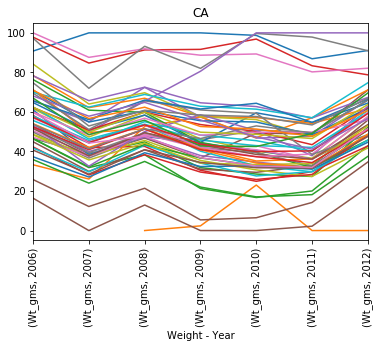

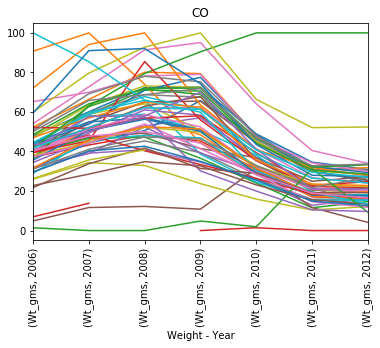

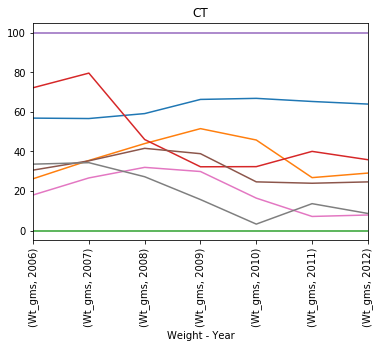

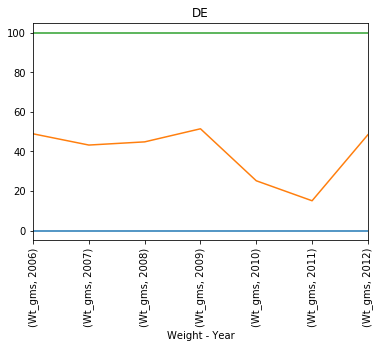

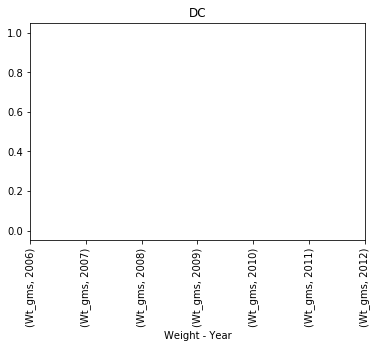

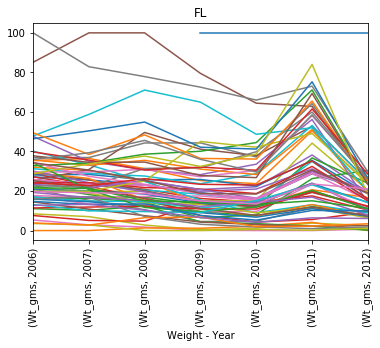

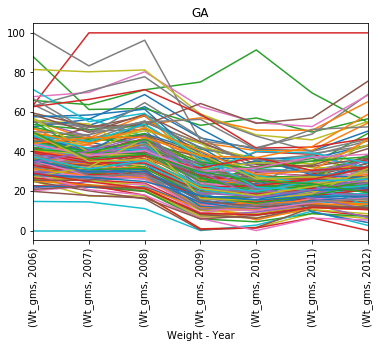

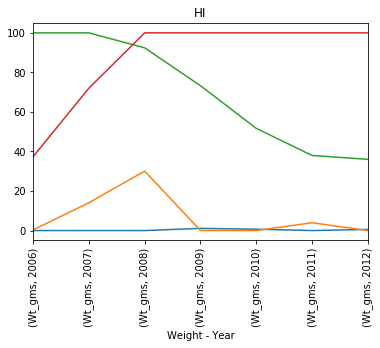

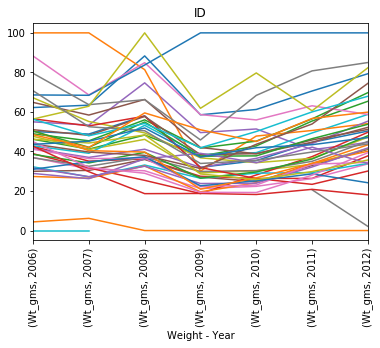

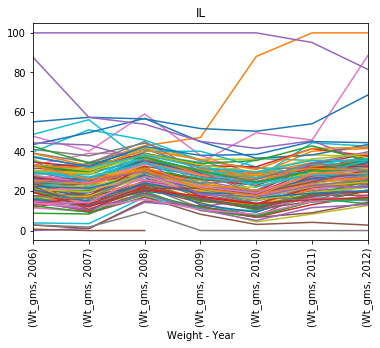

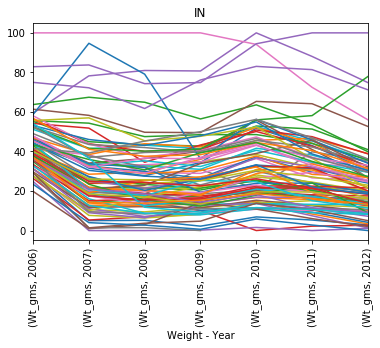

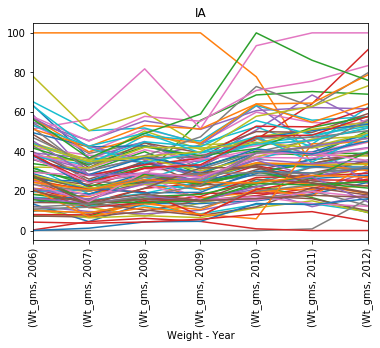

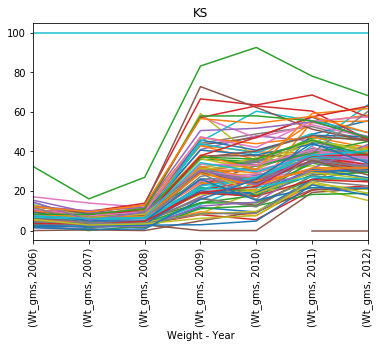

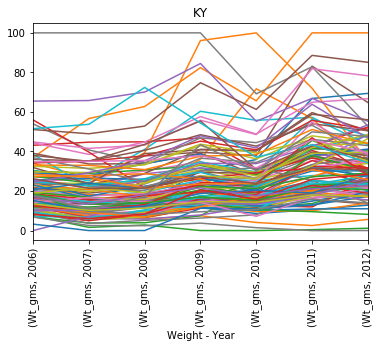

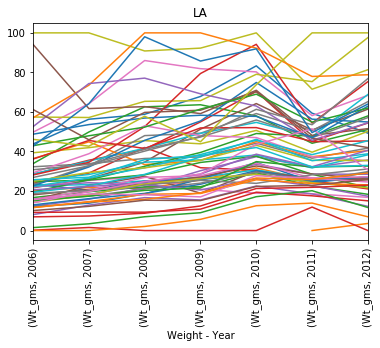

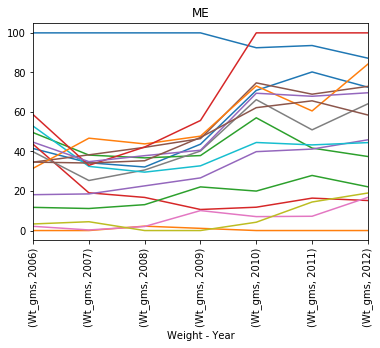

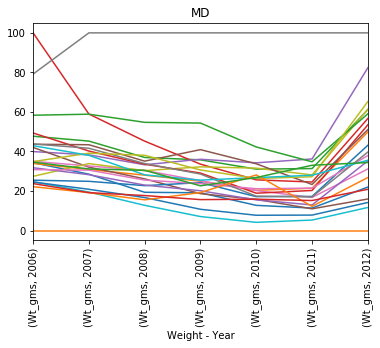

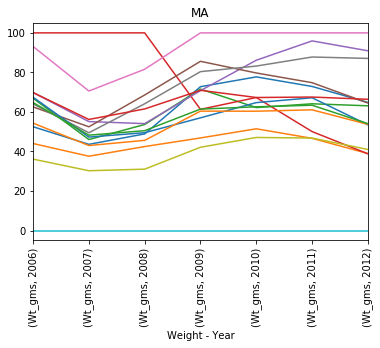

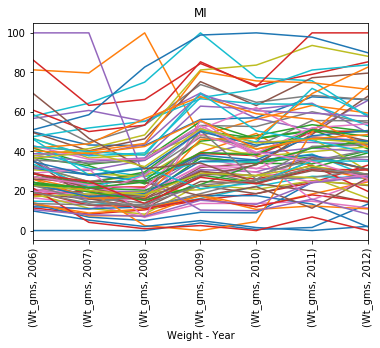

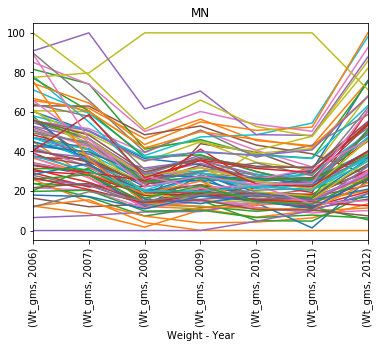

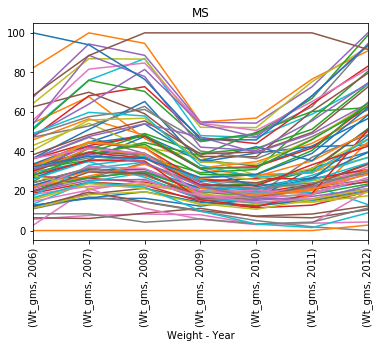

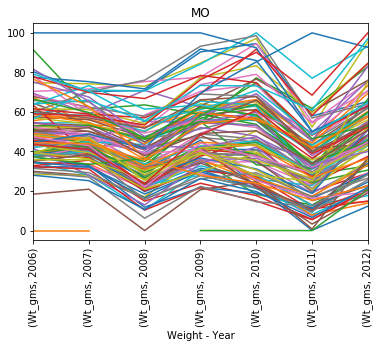

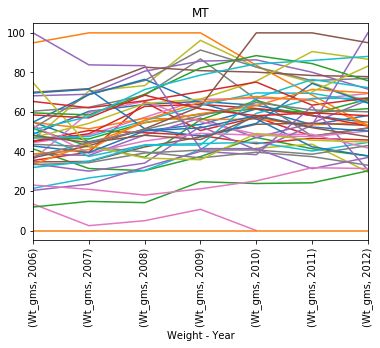

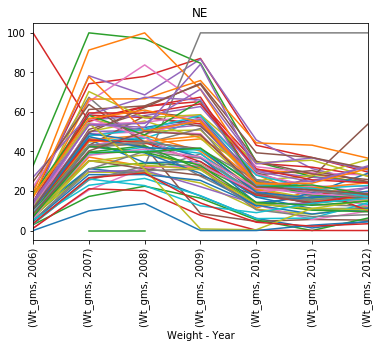

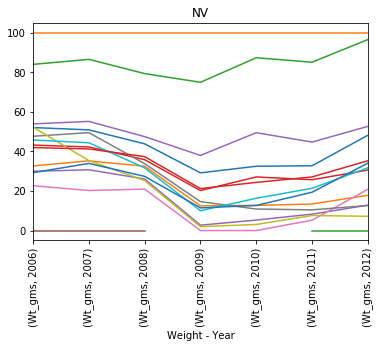

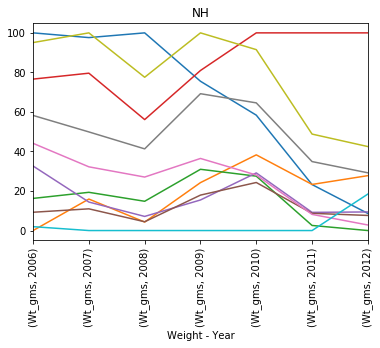

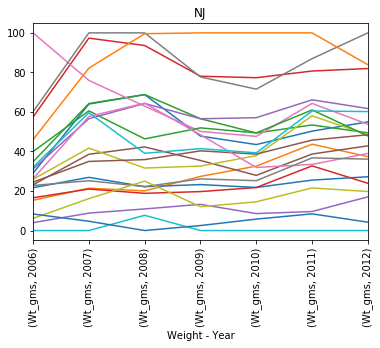

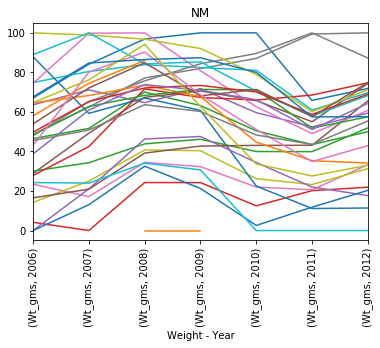

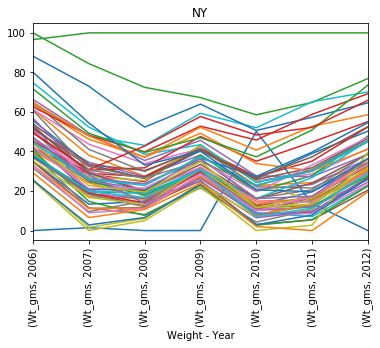

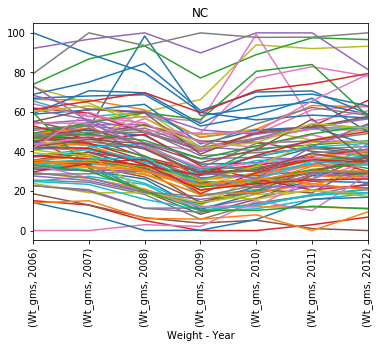

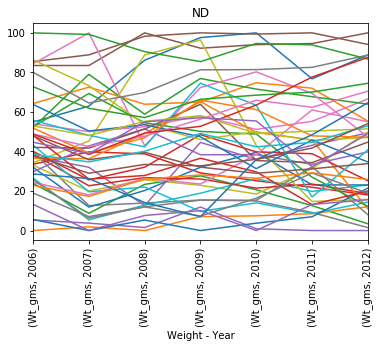

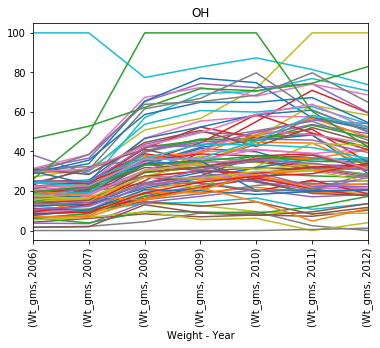

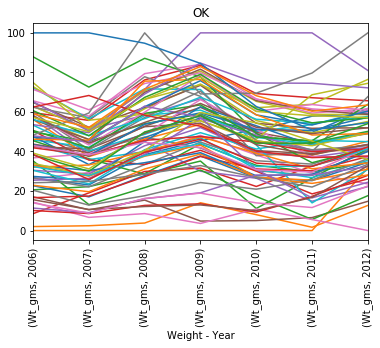

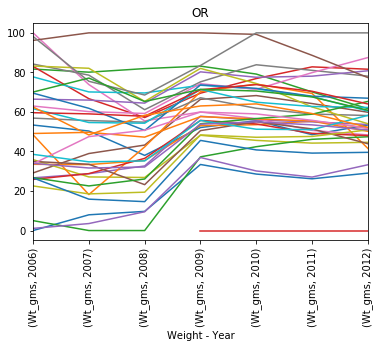

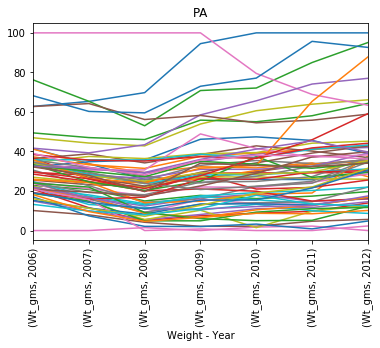

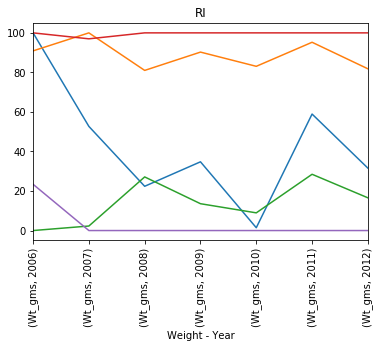

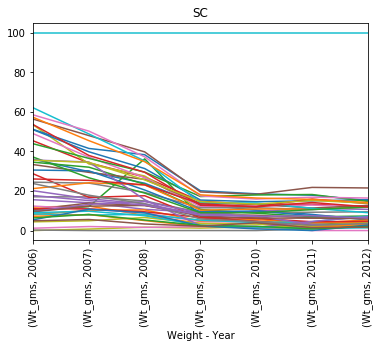

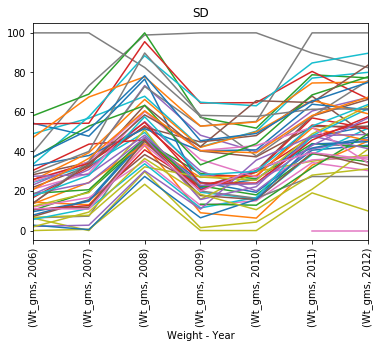

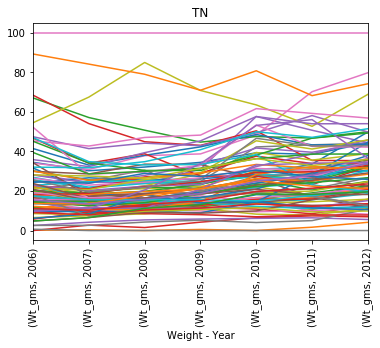

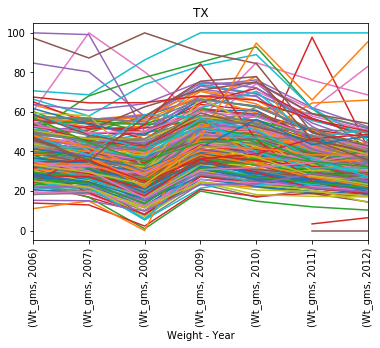

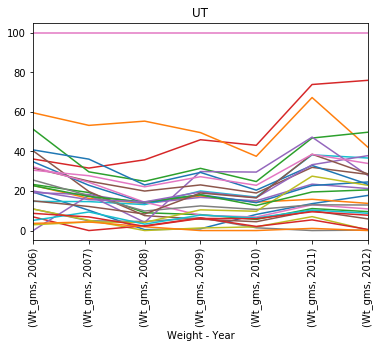

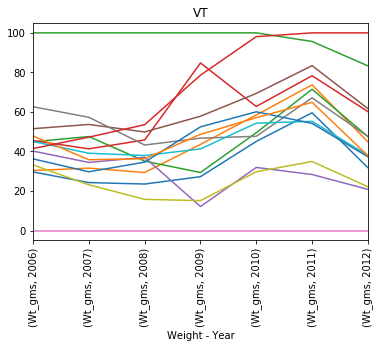

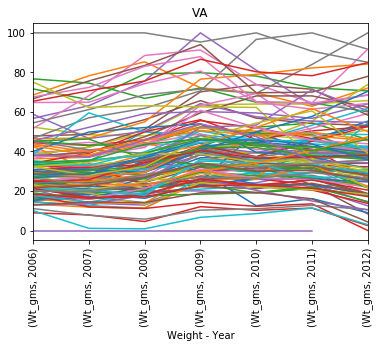

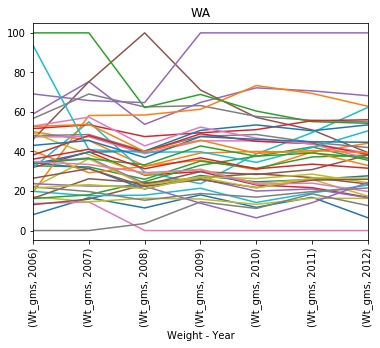

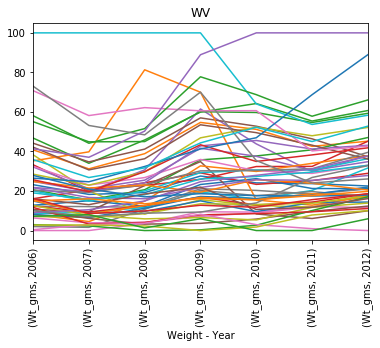

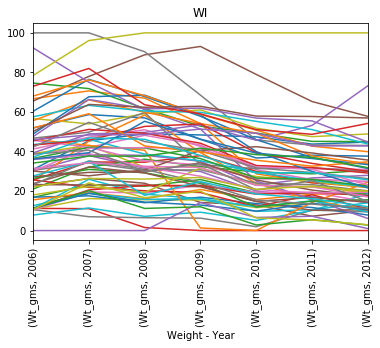

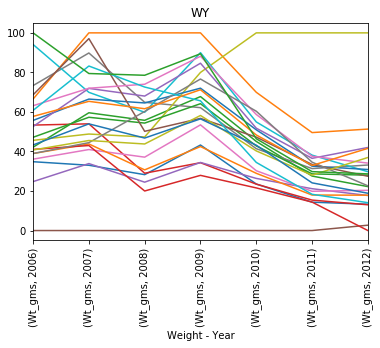

In [70]:

Targetdir="c:\\DEAdata\\StateCSVfiles\\"
suffix = '_DEA_data.csv'
States=nfips['STATE'].unique().tolist() #['VI','DE','PR']
pp.pprint(States)
fig= plt.figure(figsize=(5,3))
cntr=1
frows=15
fcols=4
for s in States:
    df=pd.read_csv(Targetdir+s+suffix)
    CountyList = df['BUYER_COUNTY'].unique()
    
    df.rename(columns={'CALC_BASE_WT_IN_GM':'Wt_gms'},inplace=True)
    #Convert Time
    df['TRANSACTION_DATE']=pd.to_datetime(pd.Series(df['TRANSACTION_DATE'] ), format="%m%d%Y")
    #Extract Year and Month
    df['year'] =df['TRANSACTION_DATE'].dt.year
    df['month'] =df['TRANSACTION_DATE'].dt.month    
    df.rename(columns={'CALC_BASE_WT_IN_GM':'Wt_gms'},inplace=True)
    dfcp = pd.pivot_table(df,index=['BUYER_COUNTY'],columns=['year'],values=['Wt_gms'])
    dfnorm=normalize(dfcp)
    dft = dfnorm.T
#     'ax = plt.subplot2grid((frows,fcols),(int(cntr/4),cntr%4),rowspan=1,colspan=1) 
#     'lineplot(ax,dft,cntr)
#     'ax= dft.plot.line(rot=90,title=s,legend=False)
#     'ax.xaxis.set_label_text("Weight - Year")'
    ax = dft.plot(kind='line',legend=False,rot=90,title =s)
    ax.xaxis.set_label_text("Weight - Year")
    plt.savefig(Targetdir+'Graphics\\'+ s + '.png')
    cntr+=1
    #ax.plot(dft,kind='line')
 

In [ ]:
# dfs =df.loc[df['BUYER_COUNTY'] == 'HARRIS']
# df1=dfs.sort_values(['TRANSACTION_DATE', 'BUYER_NAME'])
#df1

In [ ]:
# ReporterList = df['REPORTER_NAME'].unique()
#pp.pprint(ReporterList)

In [ ]:
# BuyerList = df['BUYER_NAME'].unique()

#pp.pprint(ReporterList)

In [ ]:

# df['CALC_BASE_WT_IN_GM'] 

# dfcp = pd.pivot_table(df,index=['BUYER_COUNTY'],columns=['year'],values=['CALC_BASE_WT_IN_GM'],aggfunc=np.sum)
# df1=dfcp
# #normalized_df=(df1-df1.min())/(df1.max()-df1.min())  'Normalizes the entire database to max min for the entire set
# normalized_df = normalize(df1)
 
# dft =normalized_df.T 
# #dft.style.format("{:,.3f}")
# dft

In [ ]:
# style
 
# df=dft#_normalized_df
 
# df.plot(kind='line',legend=False, rot=90,figsize=(8,20) )